In [2]:
%%capture

from lmi import lmi
import time
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm.notebook import tqdm
import torch
from scipy.stats import kendalltau

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
from bmi.estimators import MINEEstimator as MINE
from bmi.estimators import InfoNCEEstimator as InfoNCE

torch.manual_seed(2121)
np.random.seed(2121)

from torch.utils.data import DataLoader

In [3]:
def generate_gaussian_dataset(ambient, intrinsic, nuisance, antidiag, samples=10**3):
    
    assert (intrinsic*2)+nuisance <= ambient, "Dimensionality not adding up"
    
    X_nuisance = np.random.normal(size=(samples, nuisance))
    Y_nuisance = np.random.normal(size=(samples, nuisance))


    cov = np.array([[6, antidiag], [antidiag, 3.5]])
    
    pts = [np.random.multivariate_normal([0, 0], cov, 
                                         size=samples) for i in range(intrinsic)]
    
    pts = np.hstack(pts)
    
    # one copy of the intrinsic dimensions
    Xs = pts[:, [i for i in range(0, 2*intrinsic, 2)]]
    Ys = pts[:, [i for i in range(1, 2*intrinsic, 2)]]
    
    # then randomly sample them to make up the rest of the dimensions
    X_redundant = pts[:, np.random.choice(range(0, 2*intrinsic, 2), 
                                   size = (ambient-(intrinsic+nuisance)))]
    
    Y_redundant = pts[:, np.random.choice(range(1, 2*intrinsic, 2), 
                               size = (ambient-(intrinsic+nuisance)))]
    
    Xs = np.hstack((Xs, X_redundant, X_nuisance))
    Ys = np.hstack((Ys, Y_redundant, Y_nuisance))
    
    return Xs, Ys

def mi_from_rho(rho, intrinsic):
    return -0.5*np.log2((1-(rho/(np.sqrt(6*3.5)))**2))*intrinsic

def rho_from_mi(mi, intrinsic):
    return np.sqrt(6*3.5) * np.sqrt(1 - 2**(-2*mi/intrinsic))

In [6]:
def train_and_track(model, X_train, Y_train, X_test, Y_test,
          batch_size=512, lr=0.0001, epochs=300, patience=30, 
          quiet=True):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-07)
    
    train_dataloader = DataLoader(list(zip(X_train, Y_train)), 
                                batch_size=batch_size, 
                                shuffle=True)

    val_dataloader = DataLoader(list(zip(X_test, Y_test)), 
                                batch_size=batch_size, 
                                shuffle=True)
    
    variational = []
    knn = []    
    with tqdm(range(epochs), unit='Epoch', disable=quiet) as tepoch:
        for epoch in tepoch:
            
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train = X_train[indices]
            Y_train = Y_train[indices]
            
            for i, (X, Y) in enumerate(train_dataloader):
                
                model.train() 
                model_loss = model.learning_loss(X, Y)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()
            
            # mi estimation 
            with torch.no_grad():
                model.eval()
                Zx, Zy = model.encode(X_test, Y_test)
                # convert nat to bit!
                variational.append(model.InfoNCELoss(Zx, Zy).item()/-np.log(2))
                knn.append(np.nanmean(lmi.ksg.mi(Zx.cpu(), Zy.cpu())))

            tepoch.set_postfix(variational=variational[-1])
    return variational, knn 

In [7]:
v = [] # variational estimate
k = [] # knn estimate
e = [] # epoch
t = [] # trial

for i in tqdm(range(100)):
    
    Xs, Ys = generate_gaussian_dataset(100, 1, 
                                   49, 
                                   rho_from_mi(1,1),
                                  samples=5*10**3)

    Xs = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
    Ys = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()

    Xs = torch.clip(Xs, min=-10, max=10)
    Ys = torch.clip(Ys, min=-10, max=10)
    
    N_train = 2500

    indices = np.arange(len(Xs))
    np.random.shuffle(indices)

    train_indices = indices[:N_train]
    test_indices = indices[N_train:]

    X_train = Xs[train_indices]
    Y_train = Ys[train_indices]

    X_test = Xs[test_indices]
    Y_test = Ys[test_indices]

    model = lmi.models.AEInfoNCE(X_train.shape[1], Y_train.shape[1], 8, 
                                  alpha=0, lam=1).cuda()

    variational, knn = train_and_track(model, X_train, Y_train, X_test, Y_test, 
              batch_size=512, lr=10**-4, epochs=300, patience=30,
              quiet=True)
    v += variational
    
    k += knn
    e += list(range(len(knn)))
    t += [i]*len(knn)

  0%|          | 0/100 [00:00<?, ?it/s]

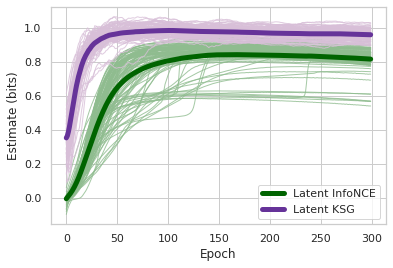

In [11]:
df = pd.DataFrame(
    {
        "Latent InfoNCE estimate (bits)" : v,
        "Latent KSG estimate (bits)" : k,
        "Epoch" : e,
        "Trial" : t
    }
)



sns.set(style='whitegrid')
sns.lineplot(df,
             x='Epoch',
            y="Latent InfoNCE estimate (bits)", lw=1,
            units='Trial', estimator=None, color='darkseagreen', alpha=0.8)
sns.lineplot(df,
             x='Epoch',
            y="Latent InfoNCE estimate (bits)", color='darkgreen',
             errorbar=None, lw=5, label='Latent InfoNCE')
sns.lineplot(df,
             x='Epoch',
            y="Latent KSG estimate (bits)", lw=1,
            units='Trial', estimator=None, color='thistle', alpha=0.8)
sns.lineplot(df,
             x='Epoch',
            y="Latent KSG estimate (bits)", 
             errorbar=None, lw=5, label='Latent KSG', color='rebeccapurple')
plt.ylabel('Estimate (bits)')
plt.show()

In [10]:
df.to_csv('../results/B_comparing_latent.csv')